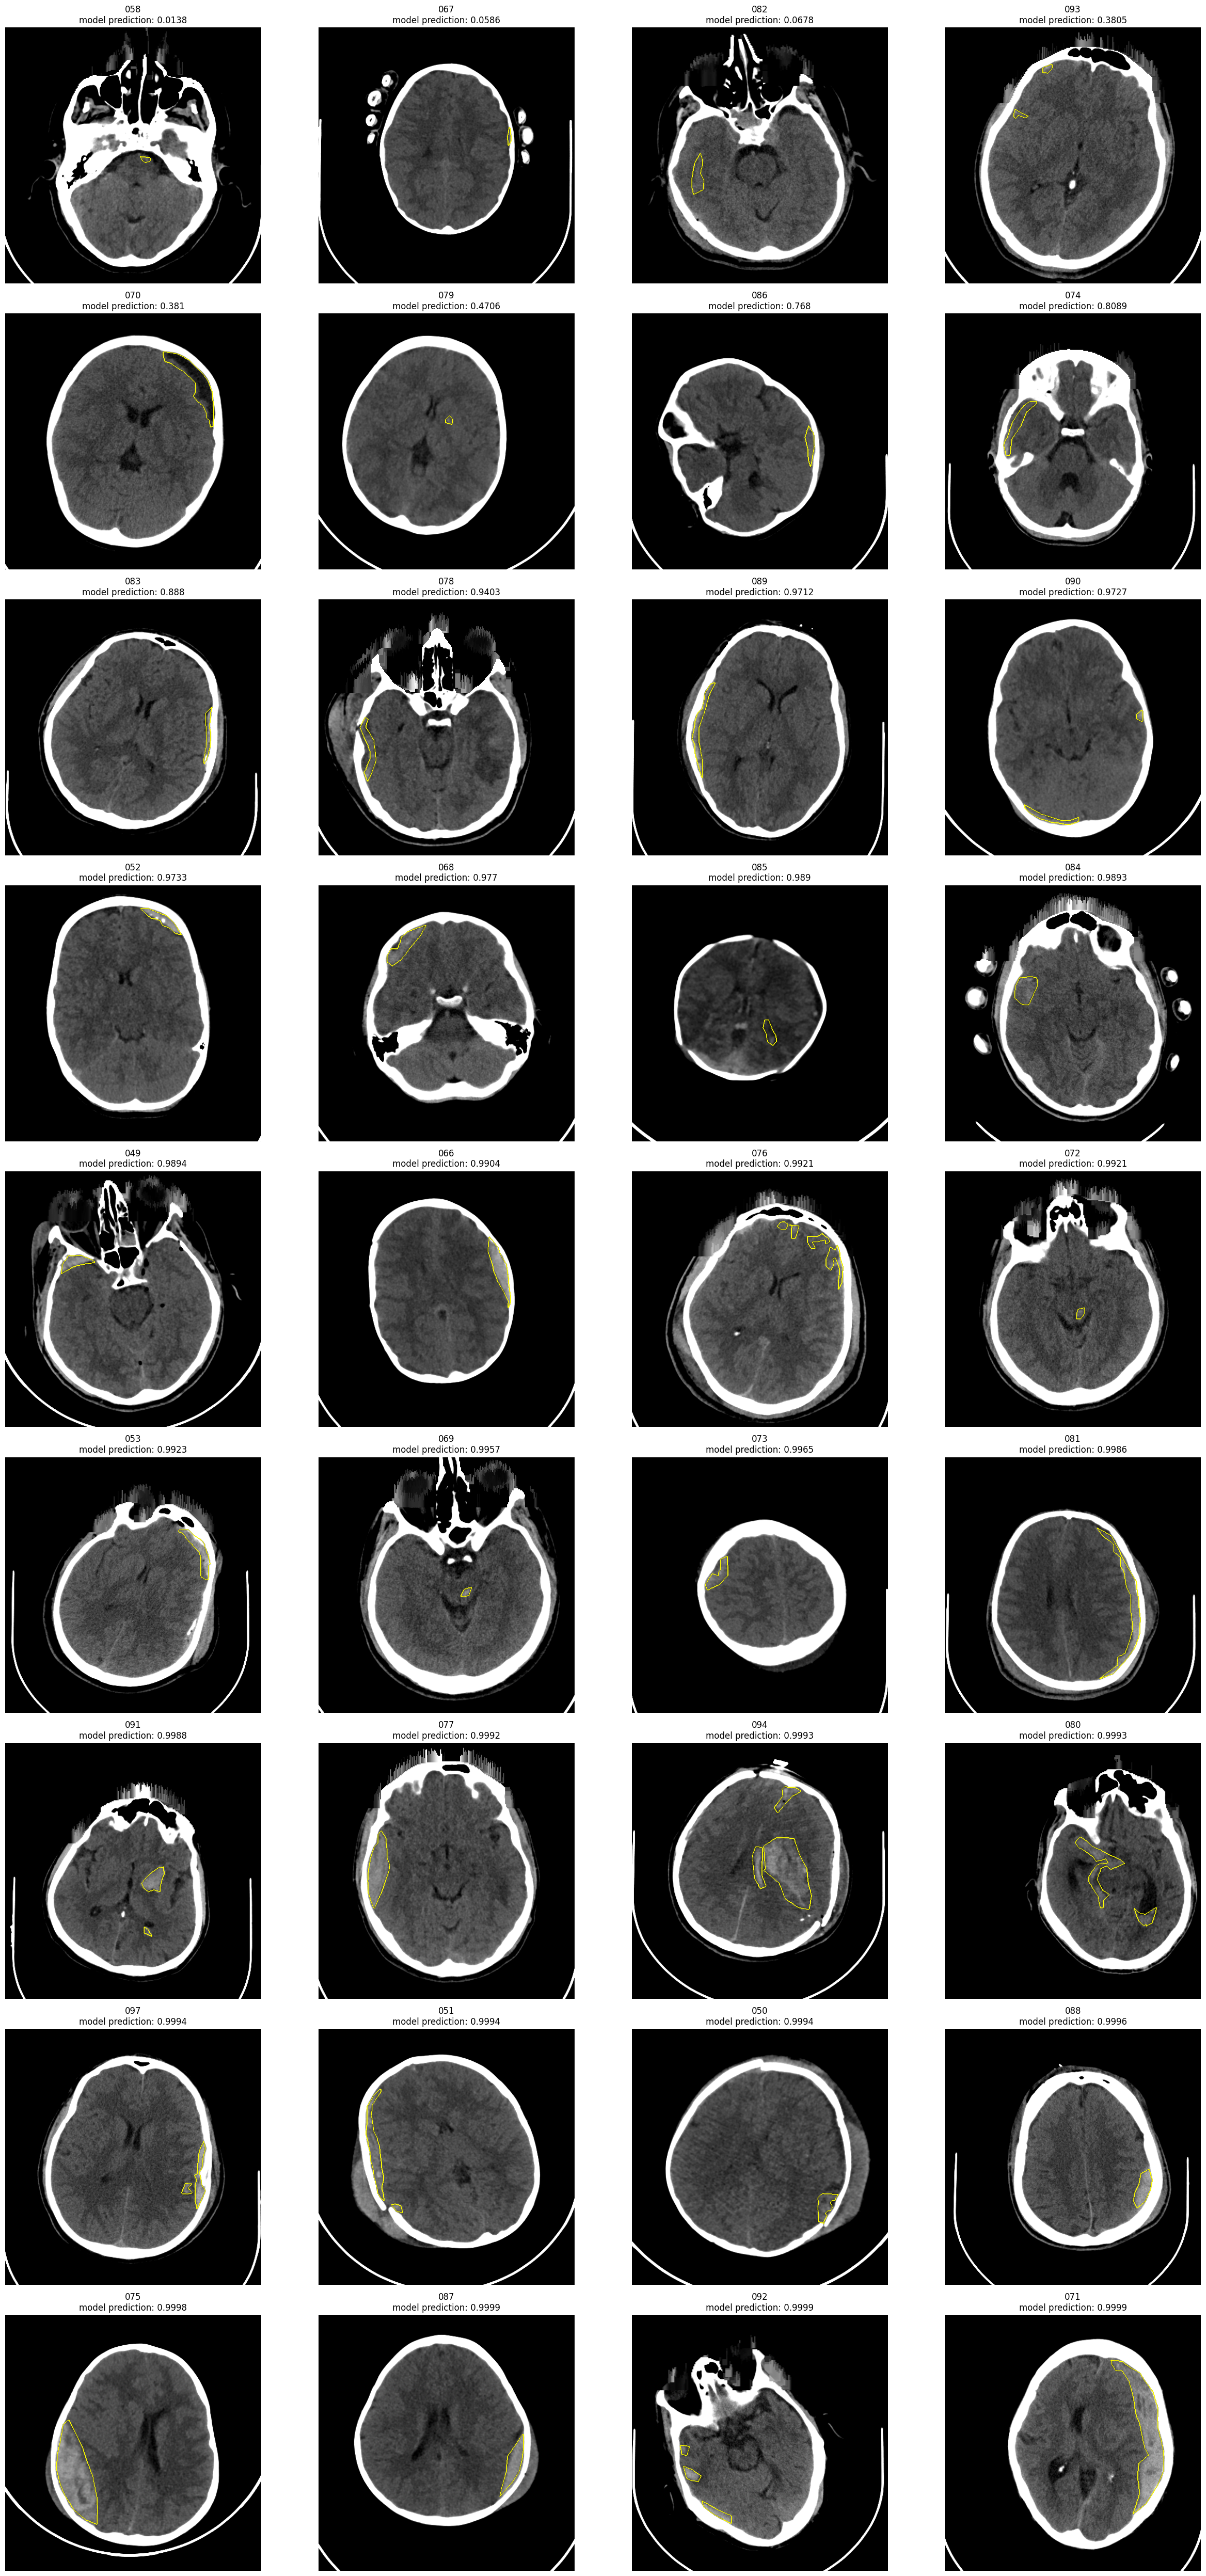

In [2]:
import sys
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski

# options
mask_method = 'boundary' # 'boundary' or 'fill'

# paths
dataset_path = '../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1'
results_df = pd.read_csv('../datasets/real_dataset_predictions.csv')

# sort by Model_Output, ascending=True will give lowest predictive value first
results_df = results_df.sort_values(by='Model_Output', ascending=True)

# just visualize the cases with hemorrhage (we're looking at the false negatives)
lesion_present_IDs = results_df[results_df['Any_ICH'] == 1]['Patient Number'].tolist()

rows = 9
cols = 4
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(25,50))
axs = axs.flat
for idx, patient in enumerate(lesion_present_IDs):
    model_pred = round(results_df[results_df['Patient Number'] == patient]['Model_Output'].item(), 4)
    patient = str(patient).zfill(3)
    
    img_vol = np.rot90(nib.load(dataset_path + '/ct_scans/' + patient + '.nii').get_fdata(), 1)
    mask = np.rot90(nib.load(dataset_path + '/masks/' + patient + '.nii').get_fdata(), 1)
    mask = np.where(mask > 0, 1, 0) # binarize mask

    # find slice with most hemorrhage voxels
    pixel_counts = []
    for i in range(mask.shape[-1]):
        pixel_counts.append(np.sum(mask[:, :, i]))

    if mask_method == 'boundary':
        mask = ski.segmentation.find_boundaries(mask[:, :, np.argmax(pixel_counts)].astype('bool'), mode='thick', background=0)
        alpha = 1.0
        cmap='spring_r'
    else:
        # mask_method == 'fill'
        alpha = 0.5
        cmap='Reds_r'

    # plot
    new_mask = np.ma.masked_where(mask == False, mask)
    axs[idx].imshow(img_vol[:, :, np.argmax(pixel_counts)], vmin=0, vmax=120, cmap='gray') # show img
    axs[idx].imshow(new_mask, cmap=cmap, alpha=alpha)

    axs[idx].set_title(f'{patient}\nmodel prediction: {model_pred}')
    axs[idx].axis('off')

plt.tight_layout()

